# TCR Engineering Analysis

## Imports

In [20]:
import sys
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Levenshtein import distance as l_dist

sys.path.append(str(Path.cwd().parent / 'tcr'))

import data_loader as dl
import mcmc
import model_utils

## Load LCMV Data

In [2]:
data_dir = Path.cwd().parent.parent / 'data'

In [3]:
lcmv = dl.load_lcmv_table(
    fname=data_dir / 'lcmv_tetramer_tcr.txt',
    metadata_fname=data_dir / 'lcmv_all_metadata.txt',
    vdj_fname=data_dir / 'lcmv_tcr_vdj_unsplit.txt'
)
lcmv.head()

INFO:root:Loaded in table of 20351 entries
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:root:16768 entries remain after dropping na
INFO:root:15028 entries remain after dropping unsorted
INFO:root:20522 entries after expanding multiple entries
INFO:root:Class TetPos: 1819
INFO:root:Class TetNeg: 17477
INFO:root:Class TetMid: 1226


,tetramer,tcr_cdr3s_aa,tcr_cdr3s_nt,TRB,TRA,nCells,Prop,TRA_nt,TRB_nt,antigen.sequence,...,S.Score,G2M.Score,Phase,phenotype,v_a_gene,d_a_gene,j_a_gene,v_b_gene,d_b_gene,j_b_gene
0,TetPos,TRA:CAFEVVGQLTF;TRB:CASSFRDSSYEQYF,TRA:TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC;TRB:TGTG...,CASSFRDSSYEQYF,CAFEVVGQLTF,3728,0.994664,TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC,TGTGCCAGCAGTTTCAGGGACAGCTCCTATGAACAGTACTTC,KAVYNFATC,...,-0.010752,-0.050206,G1,TEx,TRAV16N,None,TRAJ5,TRBV14,None,TRBJ2-7
1,TetPos,TRA:CAVSAWVGDNSKLIW;TRB:CASSRDSLTEVFF,TRA:TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATT...,CASSRDSLTEVFF,CAVSAWVGDNSKLIW,1805,0.981512,TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATTTGG,TGTGCCAGCAGCCGGGACAGCTTGACAGAAGTCTTCTTT,KAVYNFATC,...,-0.100078,-0.016706,G1,TEx,TRAV3D-3,None,TRAJ38,TRBV3,None,TRBJ1-1
2,TetPos,TRA:CAQLEGADRLTF;TRB:CASSDHTNTEVFF,TRA:TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT;TRB:T...,CASSDHTNTEVFF,CAQLEGADRLTF,1299,0.999231,TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT,TGTGCCAGCAGTGATCACACAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.112835,-0.128558,G1,TEx_progenitor,TRAV6-7-DV9,None,TRAJ45,TRBV13-3,None,TRBJ1-1
3,TetNeg,TRA:CAMSDLSNNAGAKLTF;TRB:CASSRDNNYAEQFF,TRA:TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTC...,CASSRDNNYAEQFF,CAMSDLSNNAGAKLTF,954,0.947368,TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTCACATTC,TGTGCTAGCAGCCGGGACAATAACTATGCTGAGCAGTTCTTC,KAVYNFATC,...,-0.075815,-0.128061,G1,TEx,TRAV6D-3,None,TRAJ39,TRBV17,None,TRBJ2-1
4,TetNeg,TRA:CALGLYGNEKITF;TRB:CASSVTSANTEVFF,TRA:TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT;TR...,CASSVTSANTEVFF,CALGLYGNEKITF,894,0.951064,TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT,TGTGCCAGCAGCGTGACAAGTGCAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.129156,-0.089390,G1,TEx_transitory,TRAV6N-7,None,TRAJ48,TRBV10,None,TRBJ1-1


## Deduplicate LCMV Data

In [4]:
lcmv_dedup_tra_trb, lcmv_dedup_labels = dl.dedup_lcmv_table(lcmv)
lcmv_dedup_tra, lcmv_dedup_trb = zip(*lcmv_dedup_tra_trb)
lcmv_dedup = pd.DataFrame(
    {
        "TRA": lcmv_dedup_tra,
        "TRB": lcmv_dedup_trb,
        "tetramer": lcmv_dedup_labels,
        "label": ["TetPos" in l or "TetMid" in l for l in lcmv_dedup_labels],
    }
)
lcmv_dedup.head()

INFO:root:Deduped from 20522 -> 17772 merging 101 labels
INFO:root:Combined labels [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetNeg', 55), ('TetMid,TetPos', 31), ('TetNeg,TetPos', 14), ('TetMid,TetNeg,TetPos', 1)]
INFO:root:Filtering out labels ('TetMid,TetNeg', 'TetNeg,TetPos', 'TetMid,TetNeg,TetPos')
INFO:root:Retaining 17702 pairs with unambiguous labels
INFO:root:LCMV deduped labels: [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetPos', 31)]


,TRA,TRB,tetramer,label
0,CAAAAAGNYKYVF,CASSLLGGSYEQYF,TetNeg,False
1,CAAAASNTNKVVF,CASSLGLGANTGQLYF,TetNeg,False
2,CAAAASSGSWQLIF,CASGPREANERLFF,TetNeg,False
3,CAAADNYAQGLTF,CASGEGPDYTF,TetNeg,False
4,CAAADNYAQGLTF,CASRDWGDEQYF,TetNeg,False


## Separate Positive and Negative Examples

In [5]:
lcmv_neg = lcmv_dedup.loc[lcmv_dedup['label'] == False]
lcmv_pos = lcmv_dedup.loc[lcmv_dedup['label'] == True]
lcmv_pos.head()

,TRA,TRB,tetramer,label
18,CAAAGSAGNKLTF,CASSLPGTGVDTQYF,TetPos,True
22,CAAALTGNTGKLIF,CASGERYEQYF,TetMid,True
26,CAAAMNYNQGKLIF,CASSDHSNTEVFF,TetPos,True
27,CAAAMNYNQGKLIF,CASSMWTTSAETLYF,TetPos,True
28,CAAAMNYNQGKLIF,CASSPDWGNYAEQFF,TetPos,True


## Separate Train and Test Sets

In [24]:
lcmv_train = dl.split_arr(lcmv_dedup, 'train')
lcmv_train_neg = lcmv_train.loc[~lcmv_train['label']]
lcmv_train_pos = lcmv_train.loc[lcmv_train['label']]

In [25]:
print(f'Num train negative pairs = {len(lcmv_train_neg):,}')
print(f'Num train positive pairs = {len(lcmv_train_pos):,}')
lcmv_train_pos.head()

Num train negative pairs = 10,762
Num train positive pairs = 1,630


,TRA,TRB,tetramer,label
16350,CAVSVASGSWQLIF,CASSPRAETLYF,TetMid,True
17515,CVLSGYAQGLTF,CASSDWGDEQYF,TetPos,True
11020,CAMREGGSNNRIFF,CASSEDISYNSPLYF,TetPos,True
16825,CILRVDTGYQNFYF,CASSLVWGSAETLYF,TetMid,True
3990,CAASYNAGAKLTF,CASSDWDNTEVFF,TetPos,True


In [26]:
lcmv_test = dl.split_arr(lcmv_dedup, 'test')
lcmv_test_neg = lcmv_test.loc[~lcmv_test['label']]
lcmv_test_pos = lcmv_test.loc[lcmv_test['label']]

In [28]:
print(f'Num test negative pairs = {len(lcmv_test_neg):,}')
print(f'Num test positive pairs = {len(lcmv_test_pos):,}')
lcmv_test_pos.head()

Num test negative pairs = 2,330
Num test positive pairs = 325


,TRA,TRB,tetramer,label
2564,CAASENSGTYQRF,CGAREGFEQYF,TetMid,True
12588,CATASSGSWQLIF,CASSYWGENGQLYF,TetPos,True
1185,CAANYGNEKITF,CASSFTINQDTQYF,TetPos,True
12510,CASSNTNKVVF,CTCSAVGQGAETLYF,TetMid,True
16450,CAVSYGNEKITF,CASSLLGGRGQDTQYF,TetMid,True


## Get TCR Lengths

In [9]:
test_set_pair_lens = [(len(a), len(b)) for a, b in zip(lcmv_test['TRA'], lcmv_test['TRB'])]
pair_lens = Counter(test_set_pair_lens)
pair_lens.most_common(n=3)

[((14, 14), 250), ((13, 14), 227), ((14, 15), 172)]

## Define Distance Between TCR Pairs

In [36]:
train_pos_pairs = list(zip(
    lcmv_train_pos['TRA'],
    lcmv_train_pos['TRB'],
))

def pair_dist(p1: tuple[str, str], p2: tuple[str, str]) -> int:
    """Pair dist is the sum between the distance between the TRAs and the TRBs"""
    assert len(p1) == len(p2) == 2
    dist = l_dist(p1[0], p2[0]) + l_dist(p1[1], p2[1])

    return dist

def tra_trb_dist(tra_trb_pair: tuple[str, str], ref_pairs: list[tuple[str, str]] = train_pos_pairs) -> int:
    """Minimum Levenshtein distance between the given pair and any of ref pairs"""
    dists = [pair_dist(tra_trb_pair, ref_pair) for ref_pair in ref_pairs]
    min_dist = np.min(dists)

    return min_dist

In [30]:
tra_trb_dist(('CAASGGSNNRIFF', 'CASSLGGNQDTQYF'))

6

## Load Model

In [13]:
model_dir = Path.cwd().parent.parent / 'models/lcmv_ab_finetune_cls_pooling_False_sharedencoder_0.2_dropout_25_epochs_3e-05_lr_linear_lrsched'

In [14]:
net = model_utils.load_two_part_bert_classifier(model_dir=model_dir, device=0)

## Generate Sequences

In [16]:
# Start with 100 randomly sampled negative sequences of heterogeneous length
sequences = list(zip(
    lcmv_test_neg.iloc[-100:]['TRA'],
    lcmv_test_neg.iloc[-100:]['TRB'],
))

In [17]:
# Generate sequences
per_iteration_pvalues, per_iteration_best_seqs = mcmc.generate_binding_sequences_skorch(
    net,
    sequences,
    dl.TcrFineTuneDataset,
    {"skorch_mode": True, "idx_encode": True},
    n_iter=15,
    min_prob=0.95,
    method="mlm",
    seed=6464,
    device=net.device.index,
)

INFO:root:Stopping generation, min predicted prob exceeds floor of 0.95


In [18]:
# Get final iteration TRAs and TRBs
generated_tras, generated_trbs = zip(*per_iteration_best_seqs[-1])

## Plot GP33 Binding over Iterations

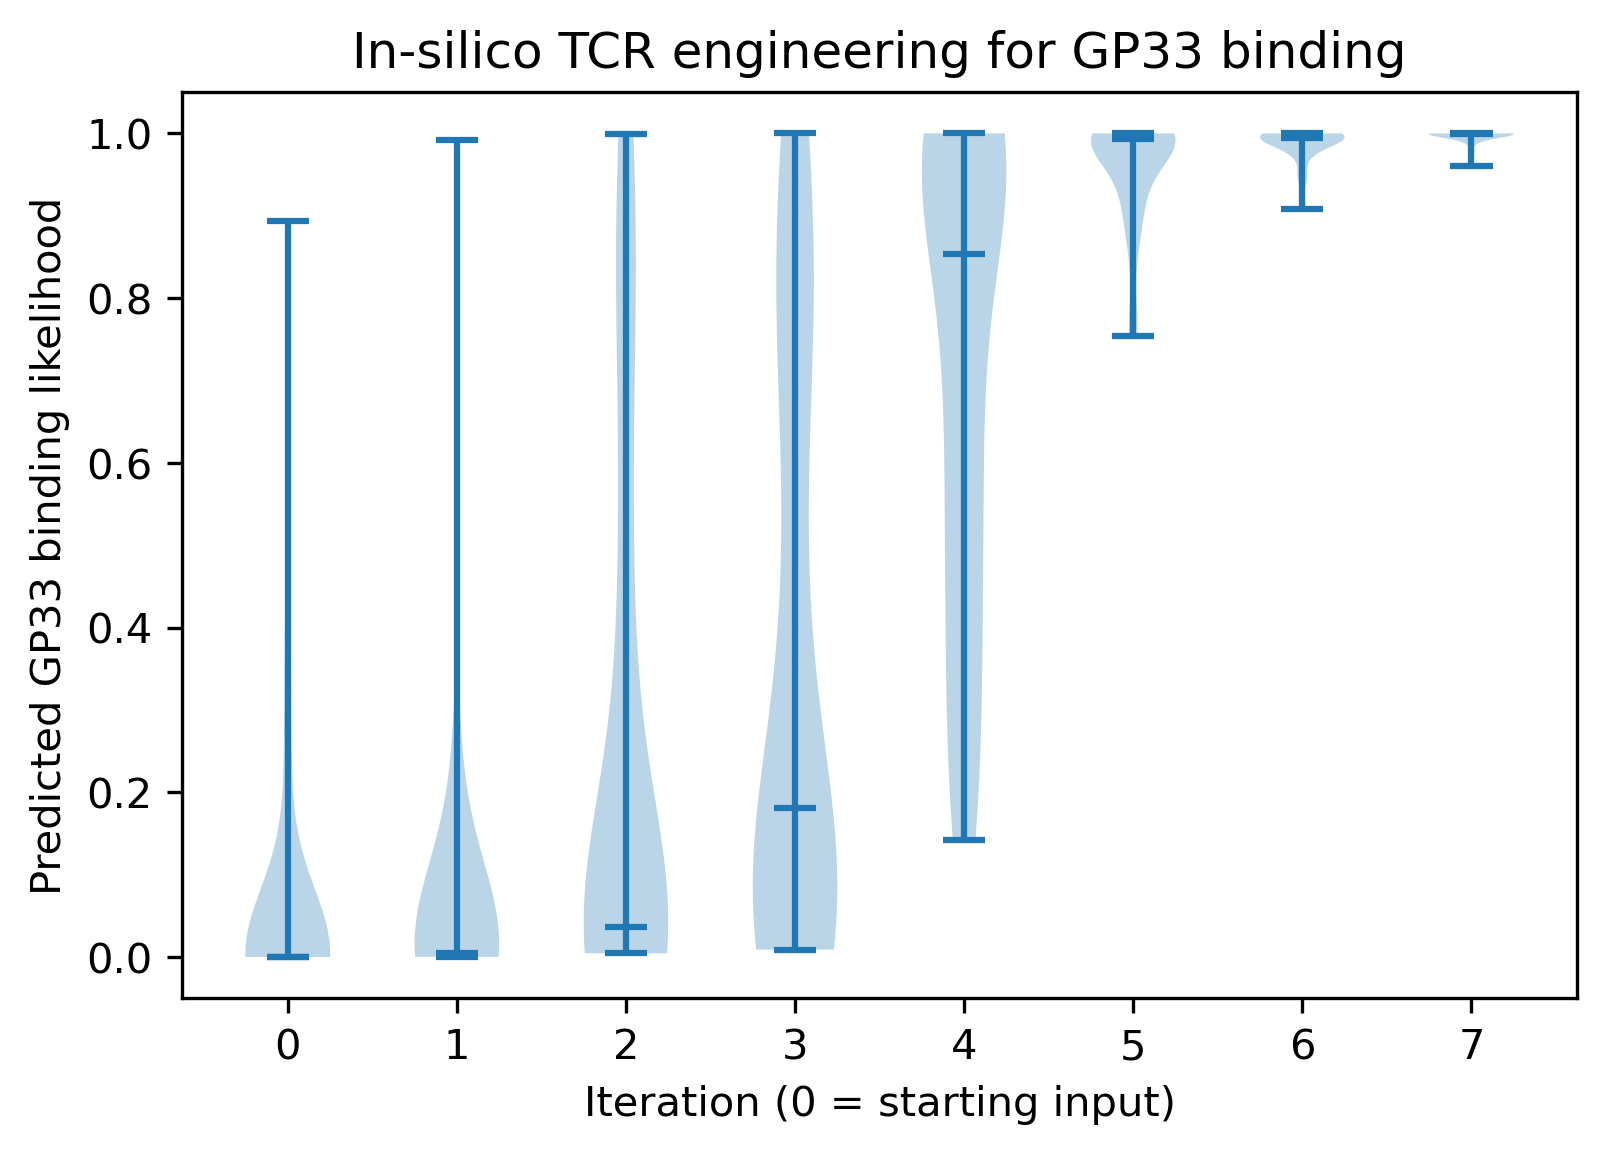

In [21]:
fig, ax = plt.subplots(dpi=300)
ax.violinplot(
    per_iteration_pvalues.T, positions=np.arange(len(per_iteration_pvalues)),
    showmedians=True, showextrema=True
)
ax.set(
    xlabel='Iteration (0 = starting input)',
    xticks=np.arange(len(per_iteration_pvalues)),
    ylabel='Predicted GP33 binding likelihood',
    title='In-silico TCR engineering for GP33 binding',
)
fig.show()

## Plot Similarity to Train Positives over Iterations

In [37]:
per_iteration_edit_distances = [[tra_trb_dist(p) for p in seq_set] for seq_set in per_iteration_best_seqs]

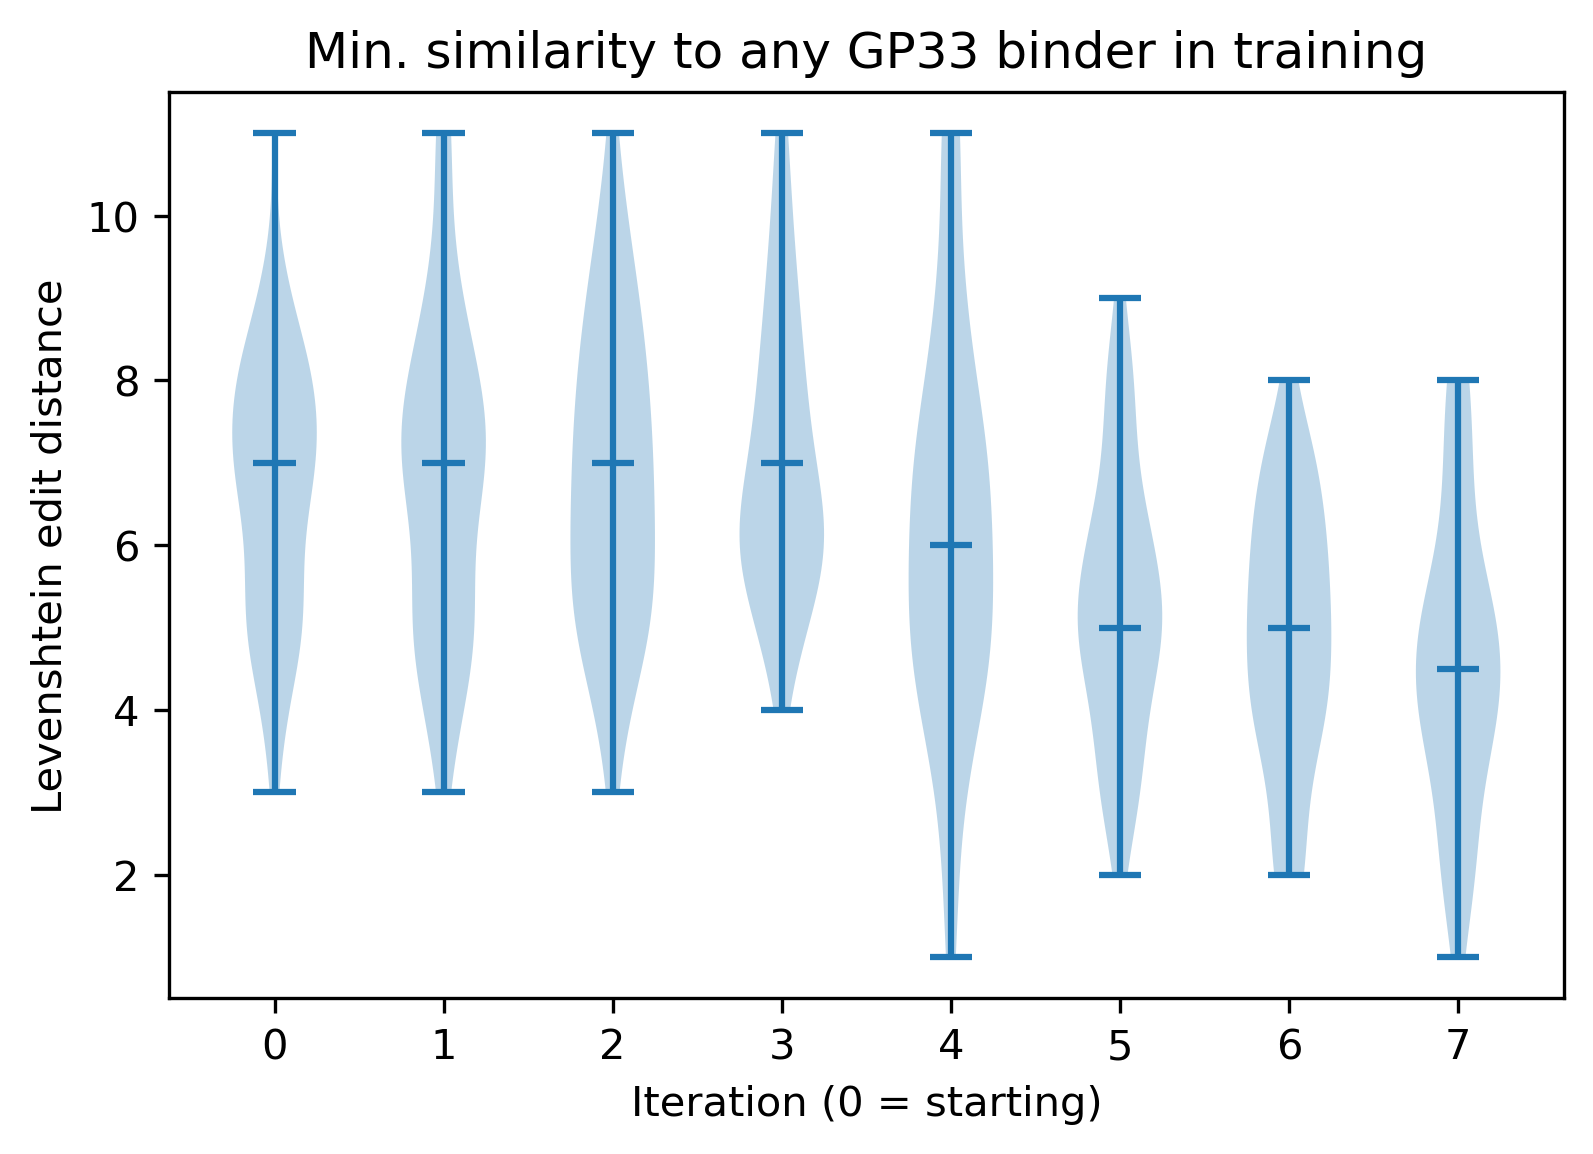

In [38]:
fig, ax = plt.subplots(dpi=300)
ax.violinplot(
    per_iteration_edit_distances, positions=np.arange(len(per_iteration_pvalues)),
    showmedians=True, showextrema=True,
)
ax.set(
    xlabel='Iteration (0 = starting)',
    xticks=np.arange(len(per_iteration_pvalues)),
    ylabel='Levenshtein edit distance',
    title='Min. similarity to any GP33 binder in training',
)
fig.show()

## UMAP to Compare Original and Generated Sequences

In [ ]:
embeds = model_utils.get_transformer_embeddings(
    model_dir='wukevin/tcr-bert',
    seqs=tras,
    seq_pair=trbs,
    layers=[-1],
    method='mean',
    device=0
)

In [ ]:
embeds.shape